In [ ]:
import pandas as pd

# Step 1: Load the datasets
# Load the demographic data
demo = pd.read_sas('/content/drive/MyDrive/ITH/DR1TOT_L.xpt')

# Load the glucose data
glu = pd.read_sas('/content/drive/MyDrive/ITH/GLU_L.XPT')


print("Unique SEQN values in demo:", demo['SEQN'].unique()[:10])
print("Unique SEQN values in glu:", glu['SEQN'].unique()[:10])

Unique SEQN values in demo: [130378. 130379. 130380. 130381. 130382. 130386. 130387. 130388. 130389.
 130390.]
Unique SEQN values in glu: [130378. 130379. 130380. 130386. 130394. 130395. 130396. 130397. 130398.
 130402.]


In [ ]:
demo.head()

,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,...,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
0,130378.0,61366.555827,70554.222162,1.0,73.0,2.0,2.0,40.0,4.0,1.0,...,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0
1,130379.0,34638.056480,36505.468348,1.0,73.0,2.0,2.0,19.0,4.0,1.0,...,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0
2,130380.0,84728.261560,103979.190677,1.0,73.0,2.0,2.0,16.0,4.0,1.0,...,NaN,2.0,NaN,2.0,NaN,1.0,4.0,2.0,NaN,2.0
3,130381.0,61737.133446,75009.220819,1.0,91.0,2.0,2.0,23.0,5.0,1.0,...,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0
4,130382.0,75846.746917,172361.851828,1.0,73.0,2.0,2.0,27.0,6.0,1.0,...,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0


In [ ]:
glu.head()

,SEQN,WTSAF2YR,LBXGLU,LBDGLUSI
0,130378.0,1.200253e+05,113.0,6.27
1,130379.0,5.397605e-79,99.0,5.50
2,130380.0,1.450908e+05,156.0,8.66
3,130386.0,8.259962e+04,100.0,5.55
4,130394.0,1.004203e+05,88.0,4.88


In [ ]:
unique_row_count = demo.nunique(axis=0)
print("Number of unique rows:", unique_row_count)

Number of unique rows: SEQN        8860
WTDRD1      6440
WTDR2D      5707
DR1DRSTZ       4
DR1EXMER      13
            ... 
DRD370T        2
DRD370TQ      19
DRD370U        2
DRD370UQ       6
DRD370V        2
Length: 168, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Step 1: Load and merge datasets on 'SEQN'
merged_data = pd.merge(demo, glu[['SEQN', 'LBXGLU']], on='SEQN', how='inner')

# Step 2: Create a target label (diabetes status)
merged_data['diabetes_status'] = merged_data['LBXGLU'].apply(lambda x: 1 if x >= 115 else 0)

# Step 3: Handle missing values
numerical_cols = merged_data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = merged_data.select_dtypes(exclude=['float64', 'int64']).columns

# Impute missing values for numerical columns
for col in numerical_cols:
    merged_data[col] = merged_data[col].fillna(merged_data[col].mean())

# Impute missing values for categorical columns
for col in categorical_cols:
    merged_data[col] = merged_data[col].fillna(merged_data[col].mode()[0])

# Step 4: Prepare features and target
X = merged_data.drop(columns=['SEQN', 'diabetes_status', 'LBXGLU'], errors='ignore')
y = merged_data['diabetes_status']

# Encode categorical variables (if any)
X = pd.get_dummies(X, drop_first=True)

# Step 5: Handle remaining missing values (if any) using SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Before applying the imputer, let's check for any columns with all missing values
X = X.loc[:, X.isnull().mean() < 1]  # Drop columns where all values are NaN

# Impute missing values for the remaining columns
X_imputed = imputer.fit_transform(X)

# Make sure the DataFrame column names are retained after transformation
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

# Step 6: Split the data into training and testing sets (80:20 split)
X_train, X_test, y_train, y_test = train_test_split(X_imputed_df, y, test_size=0.2, random_state=42)

# Step 7: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 8: Recursive Feature Elimination (RFE)
log_reg = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(estimator=log_reg, n_features_to_select=45)
rfe.fit(X_train_scaled, y_train)
rfe_selected_features = X_imputed_df.columns[rfe.support_].tolist()

# Update X_train and X_test to include only the RFE-selected features
X_train_rfe = X_train_scaled[:, rfe.support_]  # Select columns corresponding to RFE-selected features
X_test_rfe = X_test_scaled[:, rfe.support_]


# Print selected features
print("RFE Selected Features:", rfe_selected_features)

RFE Selected Features: ['WTDRD1', 'DR1LANG', 'DBQ095Z', 'DRQSPREP', 'DR1SKY', 'DRQSDIET', 'DR1TSUGR', 'DR1TMFAT', 'DR1TBCAR', 'DR1TLZ', 'DR1TVB1', 'DR1TVB2', 'DR1TFDFE', 'DR1TCHL', 'DR1TVD', 'DR1TCALC', 'DR1TPHOS', 'DR1TMAGN', 'DR1TIRON', 'DR1TSELE', 'DR1TTHEO', 'DR1TMOIS', 'DR1TS060', 'DR1TS080', 'DR1TS120', 'DR1TS180', 'DR1TM181', 'DR1TP184', 'DR1TP205', 'DR1TP225', 'DR1TP226', 'DR1_320Z', 'DR1_330Z', 'DRD350C', 'DRD350CQ', 'DRD350J', 'DRD370DQ', 'DRD370HQ', 'DRD370L', 'DRD370M', 'DRD370O', 'DRD370P', 'DRD370Q', 'DRD370QQ', 'DRD370V']


<ipython-input-10-1f1495e2a61d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=merged_data, x='diabetes_status', palette='viridis')


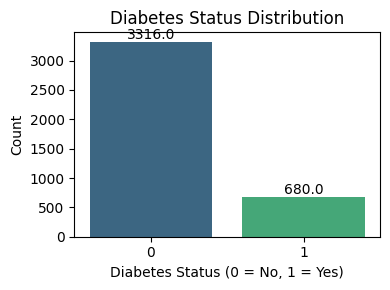

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for diabetes status distribution
plt.figure(figsize=(4, 3))
ax = sns.countplot(data=merged_data, x='diabetes_status', palette='viridis')
plt.title('Diabetes Status Distribution')
plt.xlabel('Diabetes Status (0 = No, 1 = Yes)')
plt.ylabel('Count')

# Add count annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

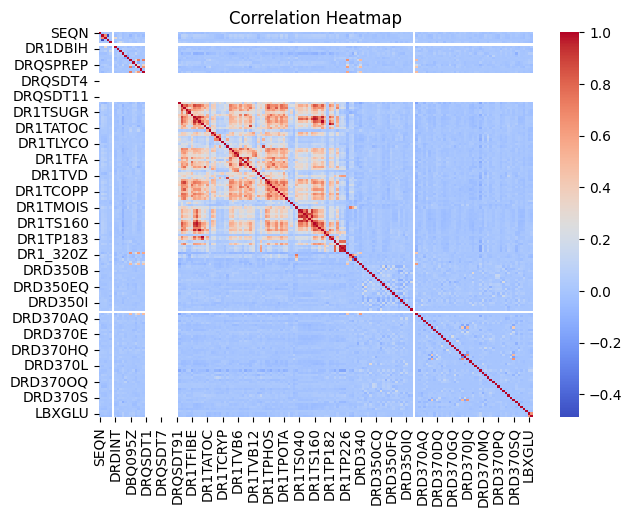

In [ ]:
# Compute correlation matrix
plt.figure(figsize=(7, 5))
correlation_matrix = merged_data.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


**model : recursive features elimination**


In [ ]:
X_train_rfe.shape,X_test_rfe.shape,y_train.shape,y_test.shape

((3196, 45), (800, 45), (3196,), (800,))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import os


class ResidualModel(nn.Module):
    def __init__(self, input_size):
        super(ResidualModel, self).__init__()

        # Input Layer
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.3)
        )

        # Residual Block 1
        self.residual_block1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3)
        )
        self.projection1 = nn.Linear(512, 256)  # Project residual connection

        # Residual Block 2
        self.residual_block2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3)
        )
        self.projection2 = nn.Linear(256, 128)  # Project residual connection

        # Output Layer
        self.output_layer = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Input pass
        x = self.input_layer(x)

        # Residual connection 1
        residual1 = self.projection1(x)  # Project dimensions
        x = self.residual_block1(x)
        x += residual1  # Add residual

        # Residual connection 2
        residual2 = self.projection2(x)  # Project dimensions
        x = self.residual_block2(x)
        x += residual2  # Add residual

        # Output pass
        return self.output_layer(x)


In [ ]:


# Focal Loss for Class Imbalance Handling
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCELoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss


# Gradient Clipping & OneCycle Scheduler Integration
def configure_optimizer_and_scheduler_with_clipping(model):
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=100, epochs=20)
    return optimizer, scheduler


# Training with Advanced Techniques
def train_advanced_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
                         criterion, optimizer, scheduler, epochs=50, patience=10):
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        # Training Phase
        model.train()
        optimizer.zero_grad()
        y_pred_train = model(X_train_tensor)
        loss = criterion(y_pred_train, y_train_tensor)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient Clipping
        optimizer.step()
        scheduler.step()

        # Validation Phase
        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test_tensor)
            val_loss = criterion(y_pred_test, y_test_tensor)

        # Early Stopping Checkpoint
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            counter = 0
            torch.save(model.state_dict(), "/content/drive/MyDrive/ITH/best_advanced_model.pth")
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        # Logging
        print(f"Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


# Main Execution Logic
if __name__ == "__main__":
    # Standardize Data Directly in Tensors
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_rfe)
    X_test_scaled = scaler.transform(X_test_rfe)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Add dimension
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)  # Add dimension

    # Initialize advanced model
    input_size = X_train_tensor.shape[1]
    model = ResidualModel(input_size)

    # Loss function & optimizer/scheduler
    criterion = FocalLoss(alpha=0.8, gamma=2)  # Handle class imbalance
    optimizer, scheduler = configure_optimizer_and_scheduler_with_clipping(model)

    # Train model with advanced techniques
    train_advanced_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
                         criterion, optimizer, scheduler, epochs=50, patience=10)


Epoch 1, Train Loss: 0.1501, Val Loss: 0.1049
Epoch 2, Train Loss: 0.0932, Val Loss: 0.0945
Epoch 3, Train Loss: 0.0663, Val Loss: 0.0886
Epoch 4, Train Loss: 0.0545, Val Loss: 0.0845
Epoch 5, Train Loss: 0.0509, Val Loss: 0.0811
Epoch 6, Train Loss: 0.0493, Val Loss: 0.0779
Epoch 7, Train Loss: 0.0529, Val Loss: 0.0746
Epoch 8, Train Loss: 0.0533, Val Loss: 0.0713
Epoch 9, Train Loss: 0.0521, Val Loss: 0.0682
Epoch 10, Train Loss: 0.0534, Val Loss: 0.0655
Epoch 11, Train Loss: 0.0522, Val Loss: 0.0635
Epoch 12, Train Loss: 0.0509, Val Loss: 0.0622
Epoch 13, Train Loss: 0.0490, Val Loss: 0.0616
Epoch 14, Train Loss: 0.0490, Val Loss: 0.0614
Epoch 15, Train Loss: 0.0479, Val Loss: 0.0613
Epoch 16, Train Loss: 0.0482, Val Loss: 0.0607
Epoch 17, Train Loss: 0.0463, Val Loss: 0.0597
Epoch 18, Train Loss: 0.0450, Val Loss: 0.0584
Epoch 19, Train Loss: 0.0439, Val Loss: 0.0573
Epoch 20, Train Loss: 0.0431, Val Loss: 0.0567
Epoch 21, Train Loss: 0.0432, Val Loss: 0.0567
Epoch 22, Train Loss: 

Train Accuracy: 0.8360, Test Accuracy: 0.8225
Train Sensitivity: 0.0353, Specificity: 0.9985, Precision: 0.8261, MER: 0.1640, GI: 0.1876, AUC: 0.6918
Test Sensitivity: 0.0071, Specificity: 0.9970, Precision: 0.3333, MER: 0.1775, GI: 0.0841, AUC: 0.5780, AUCH: 0.5780


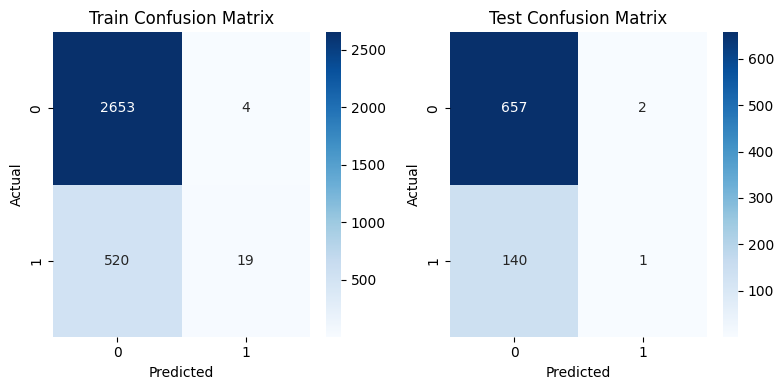

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate and print accuracy, confusion matrix, and other metrics
def print_metrics_and_confusion_matrix(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        # Train predictions
        y_train_pred = model(X_train_tensor)
        y_train_pred_binary = torch.round(y_train_pred)
        train_accuracy = accuracy_score(y_train_tensor.numpy(), y_train_pred_binary.numpy())

        # Test predictions
        y_test_pred = model(X_test_tensor)
        y_test_pred_binary = torch.round(y_test_pred)
        test_accuracy = accuracy_score(y_test_tensor.numpy(), y_test_pred_binary.numpy())

        # Compute confusion matrices
        train_cm = confusion_matrix(y_train_tensor.numpy(), y_train_pred_binary.numpy())
        test_cm = confusion_matrix(y_test_tensor.numpy(), y_test_pred_binary.numpy())

        # Extract confusion matrix components
        def extract_metrics(cm):
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall or True Positive Rate
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            mer = (fp + fn) / (tp + tn + fp + fn)  # Misclassification Error Rate
            gi = np.sqrt(sensitivity * specificity)  # Geometric Index
            return sensitivity, specificity, precision, mer, gi

        train_sensitivity, train_specificity, train_precision, train_mer, train_gi = extract_metrics(train_cm)
        test_sensitivity, test_specificity, test_precision, test_mer, test_gi = extract_metrics(test_cm)

        # ROC AUC and AUCH
        train_auc = roc_auc_score(y_train_tensor.numpy(), y_train_pred.numpy())
        test_auc = roc_auc_score(y_test_tensor.numpy(), y_test_pred.numpy())

        # Compute ROC curve for AUCH
        fpr, tpr, _ = roc_curve(y_test_tensor.numpy(), y_test_pred.numpy())
        test_auch = auc(fpr, tpr)  # Convex hull can be approximated as regular AUC here

        # Print metrics
        print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
        print(f"Train Sensitivity: {train_sensitivity:.4f}, Specificity: {train_specificity:.4f}, Precision: {train_precision:.4f}, MER: {train_mer:.4f}, GI: {train_gi:.4f}, AUC: {train_auc:.4f}")
        print(f"Test Sensitivity: {test_sensitivity:.4f}, Specificity: {test_specificity:.4f}, Precision: {test_precision:.4f}, MER: {test_mer:.4f}, GI: {test_gi:.4f}, AUC: {test_auc:.4f}, AUCH: {test_auch:.4f}")

        # Plot confusion matrices
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", ax=ax1)
        ax1.set_title('Train Confusion Matrix')
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')

        sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", ax=ax2)
        ax2.set_title('Test Confusion Matrix')
        ax2.set_xlabel('Predicted')
        ax2.set_ylabel('Actual')

        plt.tight_layout()
        plt.show()

# Call this function after training the model to print metrics and plot confusion matrices
print_metrics_and_confusion_matrix(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)


Fitting 3 folds for each of 64 candidates, totalling 192 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:55:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy (XGBoost): 0.8200
XGBoost Model saved at /content/drive/MyDrive/ITH/xgboost_model.pkl


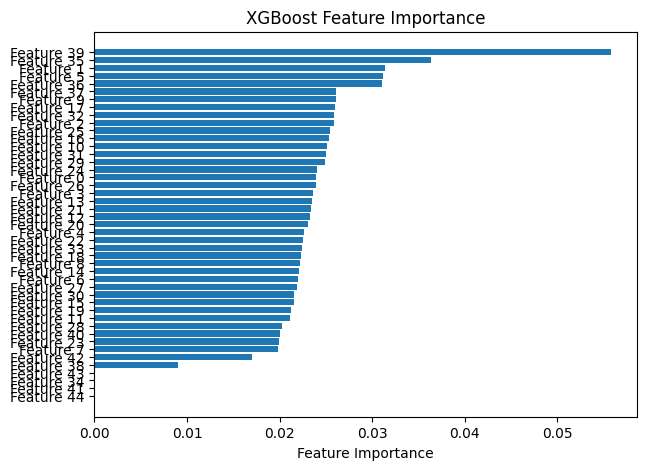

Confusion Matrix:
[[656   3]
 [141   0]]
Sensitivity: 0.0000, Specificity: 0.9954, Precision: 0.0000
MER: 0.1800, GI: 0.0000, AUC: 0.5719, AUCH: 0.5719


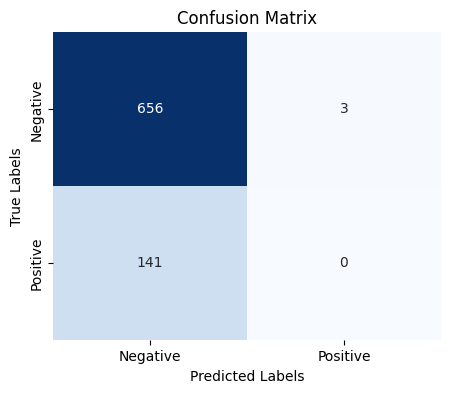

Test Accuracy: 0.8200


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, precision_score
from sklearn.model_selection import GridSearchCV
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Enhanced Train and Save XGBoost Model with Hyperparameter Tuning
def train_xgboost(X_train, y_train, X_test, y_test, save_path):
    # Hyperparameter tuning with GridSearchCV
    param_grid = {
        'learning_rate': [0.01, 0.05],
        'max_depth': [3, 5],
        'min_child_weight': [1, 2],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9],
        'n_estimators': [50, 100]
    }

    xgb_model = XGBClassifier(eval_metric="mlogloss", use_label_encoder=False)
    grid_search = GridSearchCV(xgb_model, param_grid, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Test accuracy
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy (XGBoost): {accuracy:.4f}")

    # Save XGBoost model in .pkl format
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))
    joblib.dump(best_model, save_path)  # Save model as .pkl file
    print(f"XGBoost Model saved at {save_path}")

    # Plot feature importance
    plot_feature_importance(best_model, X_train)

    # Evaluate and print metrics
    evaluate_metrics(y_test, y_pred, best_model, X_test)

    return accuracy, y_pred

# Function to plot feature importance
def plot_feature_importance(model, X_train):
    feature_importance = model.feature_importances_
    sorted_idx = feature_importance.argsort()

    feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]

    plt.figure(figsize=(7, 5))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('XGBoost Feature Importance')
    plt.show()

# Function to evaluate metrics and plot confusion matrix
def evaluate_metrics(y_true, y_pred, model, X_test):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Sensitivity, Specificity, Precision, and MER
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall or TPR
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # TNR
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    mer = (fp + fn) / (tn + tp + fn + fp)  # Misclassification Error Rate
    gi = np.sqrt(sensitivity * specificity)  # Geometric Index

    # AUC and AUCH
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_true, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auch = auc(fpr, tpr)  # Convex hull approximation

    # Print metrics
    print(f"Confusion Matrix:\n{cm}")
    print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, Precision: {precision:.4f}")
    print(f"MER: {mer:.4f}, GI: {gi:.4f}, AUC: {auc_score:.4f}, AUCH: {auch:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Define the save path for the model
save_path = "/content/drive/MyDrive/ITH/xgboost_model.pkl"

# Train and get the accuracy and predictions
accuracy, y_pred = train_xgboost(X_train_rfe, y_train, X_test_rfe, y_test, save_path)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")


Ensemble Accuracy: 0.8225
Ensemble AUC: 0.5895


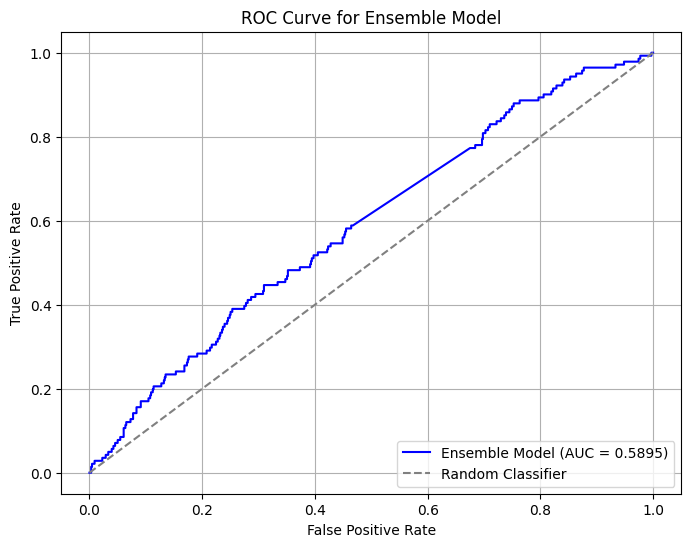

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import joblib
import torch

# Load pre-trained XGBoost model
xgb_model = joblib.load("/content/drive/MyDrive/ITH/xgboost_model.pkl")

# Generate Predictions (probabilities) from XGBoost
xgb_preds_prob = xgb_model.predict_proba(X_test_rfe)[:, 1]  # Assuming XGBoost was trained for binary classification

# Load pre-trained ResidualModel weights only
input_size = X_test_rfe.shape[1]
residual_model = ResidualModel(input_size)
residual_model.load_state_dict(torch.load("/content/drive/MyDrive/ITH/best_advanced_model.pth", weights_only=True))
residual_model.eval()

# Ensure X_test_rfe is used directly as a NumPy array
X_test_tensor = torch.tensor(X_test_rfe, dtype=torch.float32)

# Generate Predictions for ResidualModel
with torch.no_grad():
    res_preds_tensor = residual_model(X_test_tensor)
    res_preds_prob = res_preds_tensor.numpy().flatten()  # Convert tensor to NumPy

# Combine Predictions (Weighted Averaging)
ensemble_preds_prob = 0.6 * xgb_preds_prob + 0.4 * res_preds_prob
ensemble_preds = (ensemble_preds_prob >= 0.5).astype(int)  # Threshold at 0.5

# Evaluate Ensemble Performance
ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
ensemble_auc = roc_auc_score(y_test, ensemble_preds_prob)

print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble AUC: {ensemble_auc:.4f}")

# Generate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, ensemble_preds_prob)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Ensemble Model (AUC = {ensemble_auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title("ROC Curve for Ensemble Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


<ipython-input-19-698086ab0177>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  residual_model.load_state_dict(torch.load(residual_model_path))


Ensemble Accuracy: 0.8225
Ensemble AUC: 0.5895


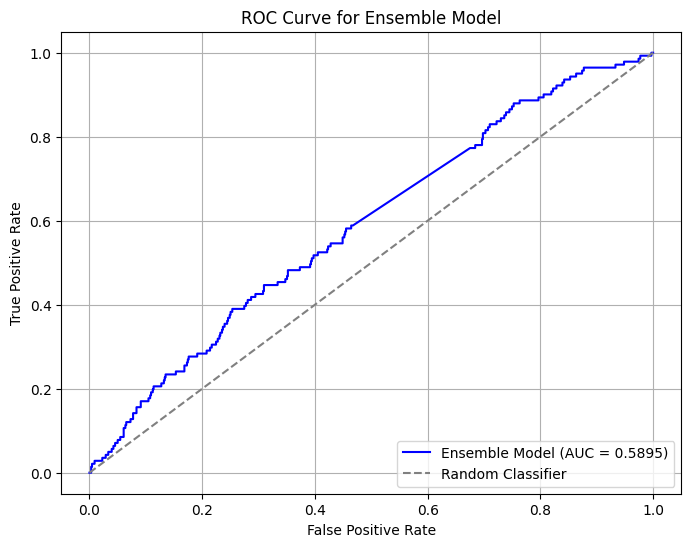

In [ ]:
import joblib
import torch
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load Pre-Trained Models
xgb_model_path = "/content/drive/MyDrive/ITH/xgboost_model.pkl"
residual_model_path = "/content/drive/MyDrive/ITH/best_advanced_model.pth"

# Load XGBoost model
xgb_model = joblib.load(xgb_model_path)

# Load Residual model
input_size = X_test_rfe.shape[1]  # Set input size from dataset
residual_model = ResidualModel(input_size)
residual_model.load_state_dict(torch.load(residual_model_path))
residual_model.eval()

# Generate predictions from XGBoost
xgb_preds_prob = xgb_model.predict_proba(X_test_rfe)[:, 1]  # Assuming binary classification

# Generate predictions from Residual Model
X_test_tensor = torch.tensor(X_test_rfe, dtype=torch.float32)
with torch.no_grad():
    res_preds_tensor = residual_model(X_test_tensor)
    res_preds_prob = res_preds_tensor.numpy().flatten()  # Convert to NumPy array

# Combine predictions (weighted averaging)
ensemble_weight_xgb = 0.6
ensemble_weight_res = 0.4
ensemble_preds_prob = (ensemble_weight_xgb * xgb_preds_prob) + (ensemble_weight_res * res_preds_prob)
ensemble_preds = (ensemble_preds_prob >= 0.5).astype(int)  # Threshold at 0.5

# Evaluate Ensemble Model
ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
ensemble_auc = roc_auc_score(y_test, ensemble_preds_prob)

print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble AUC: {ensemble_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, ensemble_preds_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Ensemble Model (AUC = {ensemble_auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title("ROC Curve for Ensemble Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


<ipython-input-21-698086ab0177>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  residual_model.load_state_dict(torch.load(residual_model_path))


Ensemble Accuracy: 0.8225
Ensemble AUC: 0.5895


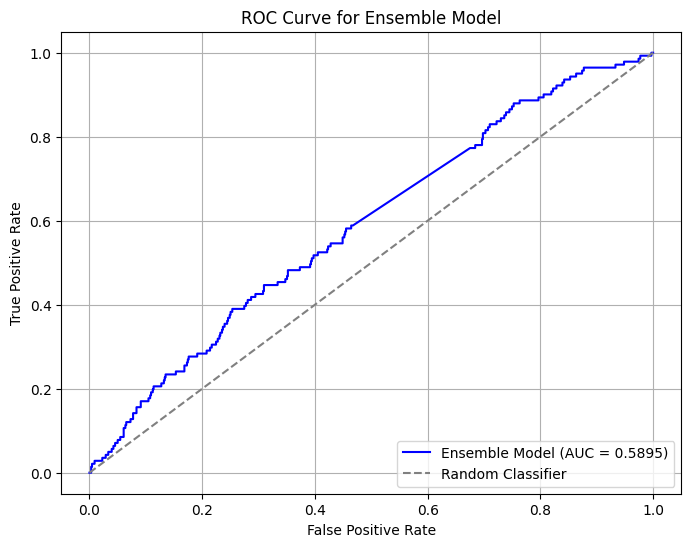

In [ ]:
import joblib
import torch
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load Pre-Trained Models
xgb_model_path = "/content/drive/MyDrive/ITH/xgboost_model.pkl"
residual_model_path = "/content/drive/MyDrive/ITH/best_advanced_model.pth"

# Load XGBoost model
xgb_model = joblib.load(xgb_model_path)

# Load Residual model
input_size = X_test_rfe.shape[1]  # Set input size from dataset
residual_model = ResidualModel(input_size)
residual_model.load_state_dict(torch.load(residual_model_path))
residual_model.eval()

# Generate predictions from XGBoost
xgb_preds_prob = xgb_model.predict_proba(X_test_rfe)[:, 1]  # Assuming binary classification

# Generate predictions from Residual Model
X_test_tensor = torch.tensor(X_test_rfe, dtype=torch.float32)
with torch.no_grad():
    res_preds_tensor = residual_model(X_test_tensor)
    res_preds_prob = res_preds_tensor.numpy().flatten()  # Convert to NumPy array

# Combine predictions (weighted averaging)
ensemble_weight_xgb = 0.6
ensemble_weight_res = 0.4
ensemble_preds_prob = (ensemble_weight_xgb * xgb_preds_prob) + (ensemble_weight_res * res_preds_prob)
ensemble_preds = (ensemble_preds_prob >= 0.5).astype(int)  # Threshold at 0.5

# Evaluate Ensemble Model
ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
ensemble_auc = roc_auc_score(y_test, ensemble_preds_prob)

print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble AUC: {ensemble_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, ensemble_preds_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Ensemble Model (AUC = {ensemble_auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title("ROC Curve for Ensemble Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
import joblib
import torch
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


# Reload XGBoost model
xgb_model_path = "/content/drive/MyDrive/ITH/xgboost_model.pkl"
xgb_model = joblib.load(xgb_model_path)

# Reload Residual Model
residual_model_path = "/content/drive/MyDrive/ITH/best_advanced_model.pth"
input_size = X_test_rfe.shape[1]  # Update this based on your dataset
residual_model = ResidualModel(input_size)
residual_model.load_state_dict(torch.load(residual_model_path))
residual_model.eval()

# Generate predictions
X_test_tensor = torch.tensor(X_test_rfe, dtype=torch.float32)

# XGBoost Predictions
xgb_preds_prob = xgb_model.predict_proba(X_test_rfe)[:, 1]

# Residual Model Predictions
with torch.no_grad():
    res_preds_tensor = residual_model(X_test_tensor)
    res_preds_prob = res_preds_tensor.numpy().flatten()

# Bagging: Simple Weighted Averaging
bagging_preds_prob = 0.5 * xgb_preds_prob + 0.5 * res_preds_prob
bagging_preds = (bagging_preds_prob >= 0.5).astype(int)

# Stacking: Meta-Classifier Approach
stack_train = np.vstack([xgb_preds_prob, res_preds_prob]).T
meta_classifier = LogisticRegression()
meta_classifier.fit(stack_train, y_test)  # Fit meta-classifier on test data for simplicity
stacking_preds_prob = meta_classifier.predict_proba(stack_train)[:, 1]
stacking_preds = (stacking_preds_prob >= 0.5).astype(int)

# Boosting: Train Gradient Boosting Classifier
boost_model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1)
boost_model.fit(stack_train, y_test)
boosting_preds_prob = boost_model.predict_proba(stack_train)[:, 1]
boosting_preds = (boosting_preds_prob >= 0.5).astype(int)

# Evaluate all ensemble models
def evaluate_ensemble(y_true, predictions_prob, method_name):
    accuracy = accuracy_score(y_true, (predictions_prob >= 0.5).astype(int))
    auc = roc_auc_score(y_true, predictions_prob)
    print(f"{method_name}: Accuracy = {accuracy:.4f}, AUC = {auc:.4f}")
    return accuracy, auc

bagging_acc, bagging_auc = evaluate_ensemble(y_test, bagging_preds_prob, "Bagging")
stacking_acc, stacking_auc = evaluate_ensemble(y_test, stacking_preds_prob, "Stacking")
boosting_acc, boosting_auc = evaluate_ensemble(y_test, boosting_preds_prob, "Boosting")

# Save the best model
best_model = None
if stacking_auc >= bagging_auc and stacking_auc >= boosting_auc:
    best_model = meta_classifier
    best_model_name = "stacking_model.pkl"
    joblib.dump(meta_classifier, f"/content/drive/MyDrive/ITH/{best_model_name}")
elif boosting_auc >= bagging_auc:
    best_model = boost_model
    best_model_name = "boosting_model.pkl"
    joblib.dump(boost_model, f"/content/drive/MyDrive/ITH/{best_model_name}")
else:
    best_model = None  # Bagging is just a weighted average, no separate model is saved

print(f"Best model: {best_model_name} with AUC = {max(bagging_auc, stacking_auc, boosting_auc):.4f}")


Bagging: Accuracy = 0.8225, AUC = 0.5895
Stacking: Accuracy = 0.8237, AUC = 0.5823
Boosting: Accuracy = 0.8525, AUC = 0.8548
Best model: boosting_model.pkl with AUC = 0.8548


<ipython-input-26-07671375cd0e>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  residual_model.load_state_dict(torch.load(residual_model_path))


In [ ]:
!pip install gradio

In [ ]:
import pandas as pd
import joblib
import torch
import numpy as np

# Load the XGBoost and Residual models
xgb_model_path = "/content/drive/MyDrive/ITH/xgboost_model.pkl"
residual_model_path = "/content/drive/MyDrive/ITH/best_advanced_model.pth"
boosting_model_path = "/content/drive/MyDrive/ITH/boosting_model.pkl"

# Load models
xgb_model = joblib.load(xgb_model_path)

input_size = 45  # Ensure this matches the trained model's feature count
residual_model = ResidualModel(input_size)
residual_model.load_state_dict(torch.load(residual_model_path, map_location=torch.device('cpu')))
residual_model.eval()

# Load Boosting Model
boosting_model = joblib.load(boosting_model_path)

# Feature list (ensure this matches your training dataset)
feature_list = [
    'WTDRD1', 'DR1LANG', 'DBQ095Z', 'DRQSPREP', 'DR1SKY', 'DRQSDIET', 'DR1TSUGR',
    'DR1TMFAT', 'DR1TBCAR', 'DR1TLZ', 'DR1TVB1', 'DR1TVB2', 'DR1TFDFE', 'DR1TCHL',
    'DR1TVD', 'DR1TCALC', 'DR1TPHOS', 'DR1TMAGN', 'DR1TIRON', 'DR1TSELE', 'DR1TTHEO',
    'DR1TMOIS', 'DR1TS060', 'DR1TS080', 'DR1TS120', 'DR1TS180', 'DR1TM181', 'DR1TP184',
    'DR1TP205', 'DR1TP225', 'DR1TP226', 'DR1_320Z', 'DR1_330Z', 'DRD350C', 'DRD350CQ',
    'DRD350J', 'DRD370DQ', 'DRD370HQ', 'DRD370L', 'DRD370M', 'DRD370O', 'DRD370P',
    'DRD370Q', 'DRD370QQ', 'DRD370V'
]

# Preprocessing function
def preprocess(data):
    """
    Preprocess the input data to select only the relevant features.
    """
    # Select only the columns in the feature list
    data = data[feature_list].copy()

    # Handle missing values
    data = data.fillna(0)

    # Ensure all columns are numeric
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = pd.to_numeric(data[col], errors='coerce')
    data = data.fillna(0)

    return data

# Function to process the uploaded CSV file and predict
def process_and_predict(file):
    try:
        # Load the CSV file
        data = pd.read_csv(file.name)
    except Exception as e:
        return f"Error reading the CSV file: {e}"

    print("CSV File Preview:")
    print(data.head())

    try:
        # Preprocess data
        data = preprocess(data)
    except Exception as e:
        return f"Error during preprocessing: {e}"

    try:
        # Generate base model predictions
        xgb_preds_prob = xgb_model.predict_proba(data)[:, 1]
        data_tensor = torch.tensor(data.values, dtype=torch.float32)
        with torch.no_grad():
            res_preds_prob = residual_model(data_tensor).numpy().flatten()

        # Stack predictions
        stacked_preds = np.vstack([xgb_preds_prob, res_preds_prob]).T

        # Predict using the ensemble model
        final_preds = boosting_model.predict(stacked_preds)
        final_labels = ["Non-Diabetic" if pred == 0 else "Diabetic" for pred in final_preds]

        return pd.DataFrame({"Prediction": final_preds, "Label": final_labels}).to_string(index=False)

    except Exception as e:
        return f"Error during prediction: {e}"

# Define the Gradio interface
import gradio as gr
interface = gr.Interface(
    fn=process_and_predict,
    inputs=gr.File(label="Upload CSV File"),
    outputs=gr.Textbox(label="Predictions"),
    title="Diabetes Prediction",
    description="Upload a CSV file to predict whether the individual is Non-Diabetic (0) or Diabetic (1).",
)

# Launch the interface
interface.launch(share=True)


<ipython-input-31-efb1d487d207>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  residual_model.load_state_dict(torch.load(residual_model_path, map_location=torch.device('c

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1b5cefbd67ac7b6ec9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
